# Automatically running electronic structure calculations linked to AIMQB calculations

The primary electronic structure software that `aiida-aimall` is integrated with is Gaussian software. Here, a base functionality is provided to run an AIMQB calculation on the .wfx file resulting from a Gaussian calcuation. The [GaussianToAIMWorkChain](../reference/api/auto/aiida_aimall/workchains/index.rst#aiida_aimall.workchains.GaussianToAIMWorkChain) accepts any **one** of the following as inputs:
 - `smiles`, the SMILES of the molecule provided as type `orm.Str`
 - `structure`, an `orm.StructureData` of the molecule
 - `xyz_file`, a `orm.SinglefileData` of a .xyz file

Note that if `smiles` is provided as input, `aiida-aimall` uses an MMFFOptimization from RDKIT to generate an input structure for the SMILES. The process of setting up this type of calculation for `structure` input is provided below.

In [5]:
from aiida import load_profile
from aiida.plugins import WorkflowFactory,DataFactory
from aiida.orm import Dict, StructureData, load_code
import io
import ase.io
from aiida.engine import submit
load_profile()
GaussianToAIMWorkChain = WorkflowFactory('aimall.gausstoaim')
AimqbParameters = DataFactory('aimall.aimqb')

gaussian_input = Dict(
                {
                    "link0_parameters": {
                        "%chk": "aiida.chk",
                        "%mem": "3200MB",  # Currently set to use 8000 MB in .sh files
                        "%nprocshared": 4,
                    },
                    "functional": "wb97xd",
                    "basis_set": "aug-cc-pvtz",
                    "charge": 0,
                    "multiplicity": 1,
                    "route_parameters": {"opt": None, "Output": "WFX"},
                    "input_parameters": {"output.wfx": None},
                })
aim_input = AimqbParameters({'nproc':2,'naat':2,'atlaprhocps':True})
# For tutorial purpose, representing a xyz file as a string, and parsing it to get strcutre data
f = io.StringIO(
                "5\n\n C -0.1 2.0 -0.02\nH 0.3 1.0 -0.02\nH 0.3 2.5 0.8\nH 0.3 2.5 -0.9\nH -1.2 2.0 -0.02"
            )
struct_data = StructureData(ase=ase.io.read(f, format="xyz"))
f.close()
builder = GaussianToAIMWorkChain.get_builder()
builder.g16_params = gaussian_input
builder.aim_params = aim_input
builder.structure = struct_data
builder.gauss_code = load_code('gaussian@localhost')
builder.aim_code = load_code('aimall@localhost')
submit(builder)

/Users/chemlab/anaconda3/envs/aiida/lib/python3.12/site-packages/aiida/storage/psql_dos/backend.py:271: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed
  with session.begin_nested() as savepoint:
/Users/chemlab/anaconda3/envs/aiida/lib/python3.12/site-packages/aiida/storage/psql_dos/orm/querybuilder/main.py:182: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  result = build.query.count()


<WorkChainNode: uuid: ac8a3caa-0d92-4383-8721-bf0026f412ff (pk: 114349) (aiida.workflows:aimall.g16toaim)>

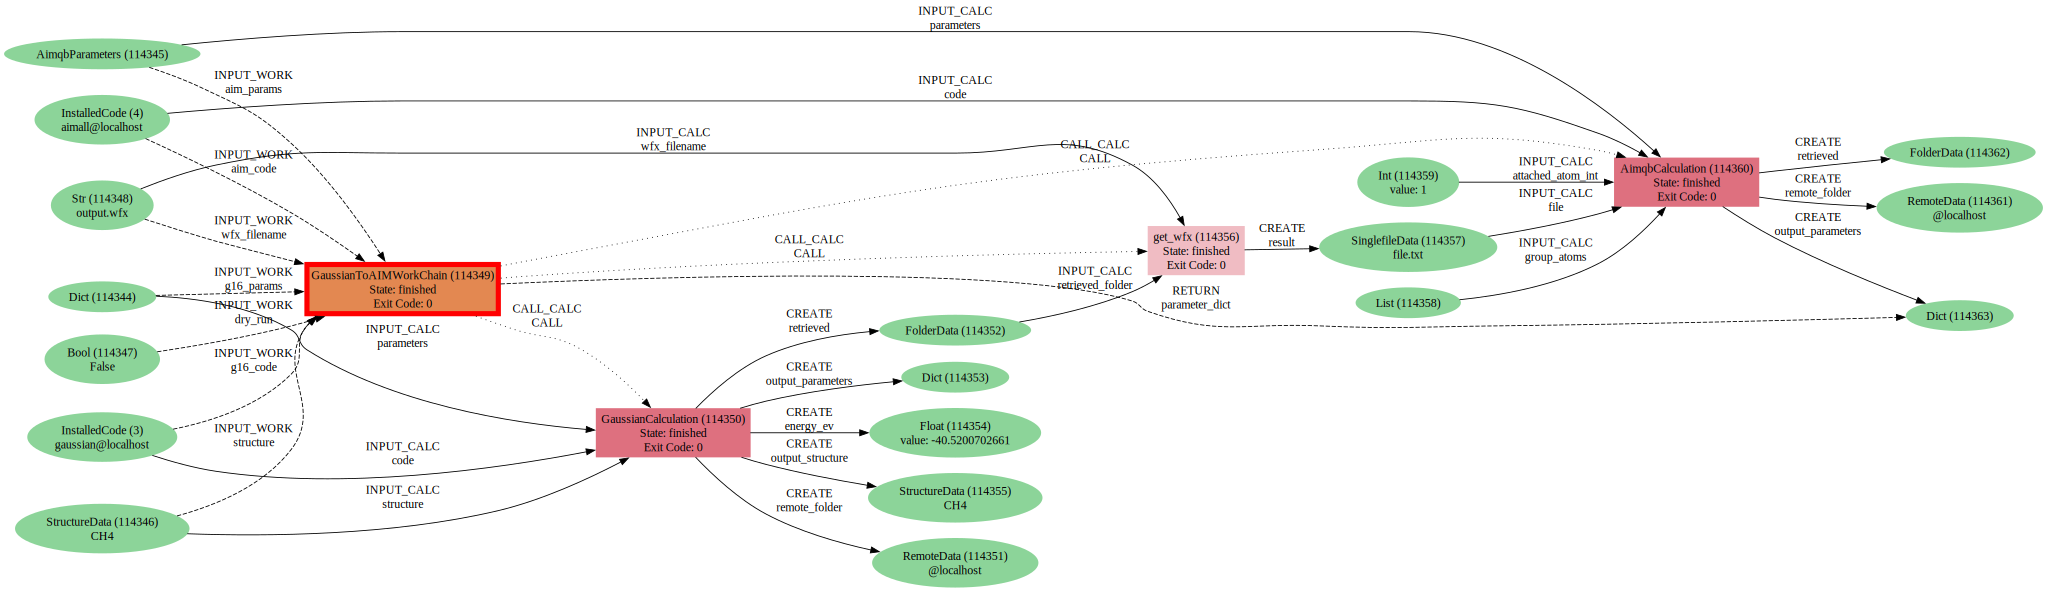

In [4]:
from aiida.tools.visualization import Graph
graph = Graph(graph_attr={"size": "6,6!", "rankdir": "LR"})
graph = Graph(graph_attr={"rankdir": "LR"})
graph.recurse_descendants(
    114349,
    origin_style=None,
    include_process_inputs=True,
    annotate_links="both"
)
graph.graphviz

Here, the main output of the workchain is specified as the output parameters of the [AimqbCalculations](../reference/api/auto/aiida_aimall/calculations/index.rst#aiida_aimall.calculations.AimqbCalculation). The structure of this has been discussed in other tutorials. The provenance graph is displayed to see. Gaussian output can be queried for.

## Other inputs

The wfx filename defaults to output.wfx, you can specify that in the Gaussian input input_parameters section. If you specify a filename other than output.wfx, supply the filename to inputs

```python
builder.inputs.wfx_filename = Str('your_wfx_filename.wfx')
```

Further, you can also supply some information to store various nodes in groups. You can provide `wfx_group` as a node to put wfx files in, or `gaussian_group` for a group to store the Gaussian node as an `Str`. Provided as an option due to the authors' use case, a `fragment_label` `Str` can also be provided to stores as the smiles extra on the node.

## Using other Electronic Structure Software

Options are provided for integrating other electronic structure software through the use of `aiida-shell`, as provided in the [QMToAIMWorkchain](../reference/api/auto/aiida_aimall/workchains/index.rst#aiida_aimall.workchains.QMToAIMWorkchain). An example is given here for ORCA software. For this, you can provide a setup `ShellCode` instance for the code being run, or a `Str` of the command used to run the software. 

### Author's Note on `shell_code` input options

The authors note that by default settings on some compute clusters, AiiDA commands may be restricted. In the author's case, providing "orca" to the input results in an error due to the script used in Multifactor Authentication, due to attempts to use the `which orca` command. In light of this, depending on your compute resources, the authors suggest setting up a `ShellCode` instance.

```python
from aiida_shell import ShellCode
from aiida.orm import load_computer

code = ShellCode(label = 'orca',
    computer = load_computer('localhost'),
    filepath_executable='/Applications/orca/orca',
    default_calc_job_plugin='core.shell',
    with_mpi=False)

```

In [19]:
from aiida_shell import ShellCode
from aiida.orm import load_computer, List, SinglefileData, Str, load_code
QMToAIMWorkchain = WorkflowFactory('aimall.qmtoaim')
# already have an orca code setup,  you can use the codeblock above to do so

code = load_code('orca@cedar')
builder = QMToAIMWorkchain.get_builder()
builder.shell_code = code
builder.shell_metadata = Dict(
    {
        'options': {
            'withmpi': False,
            # modules for the compute cluster to load
            'prepend_text': 'module load StdEnv/2020; module load gcc/10.3.0; module load openmpi/4.1.1; module load orca/5.0.4',
            'resources': {
                'num_machines': 1,
                'num_mpiprocs_per_machine': 4,
            },
            'max_memory_kb': int(3200 * 1.25) * 1024,
            'max_wallclock_seconds': 3600
        }
    }
)
# again, for tutorial, using a string parsed as file in place of providing an input file
input_file = SinglefileData(io.BytesIO('! B3LYP def2-SVP Opt AIM PAL4\n*xyz 0 1\nH 0.0 0.0 0.0\nH 0.0 0.0 1.0\n*'.encode()))
builder.shell_input_file = input_file
# get the resulting wfx and opt file, the above command creates a file file.txt so we replace the txt with the output extensions we want
builder.shell_retrieved = List([input_file.filename.replace('txt','wfx'),input_file.filename.replace('txt','opt'),])
builder.shell_cmdline = Str('{file}')
builder.aim_code = load_code('aimall@localhost')
builder.aim_params = AimqbParameters({'nproc':2,'naat':2,'atlaprhocps':True})

submit(builder)


<WorkChainNode: uuid: 025e0a64-6a77-4012-9455-851e08e1b60c (pk: 114388) (aiida.workflows:aimall.qmtoaim)>

Here, the relevant ORCA output files requested are directly stored on the provenance graph. No parser is provided, though the ability to define parsers is available in `aiida-shell`. For the purposes of `aiida-aimall` you can specify which files you want, get them and manually parse the content. [Documentation on using custom parsers can be found here.](https://aiida-shell.readthedocs.io/en/latest/howto.html#custom-output-parsing) The authors recommend creating a fork of `aiida-aimall`, adding the parser function you wish to use to the `workchains.py` file, and providing `parser=your_parser_function_name` to `launch_shell_job` in the `QMToAIMWorkchain` if you wish to use a custom parser.

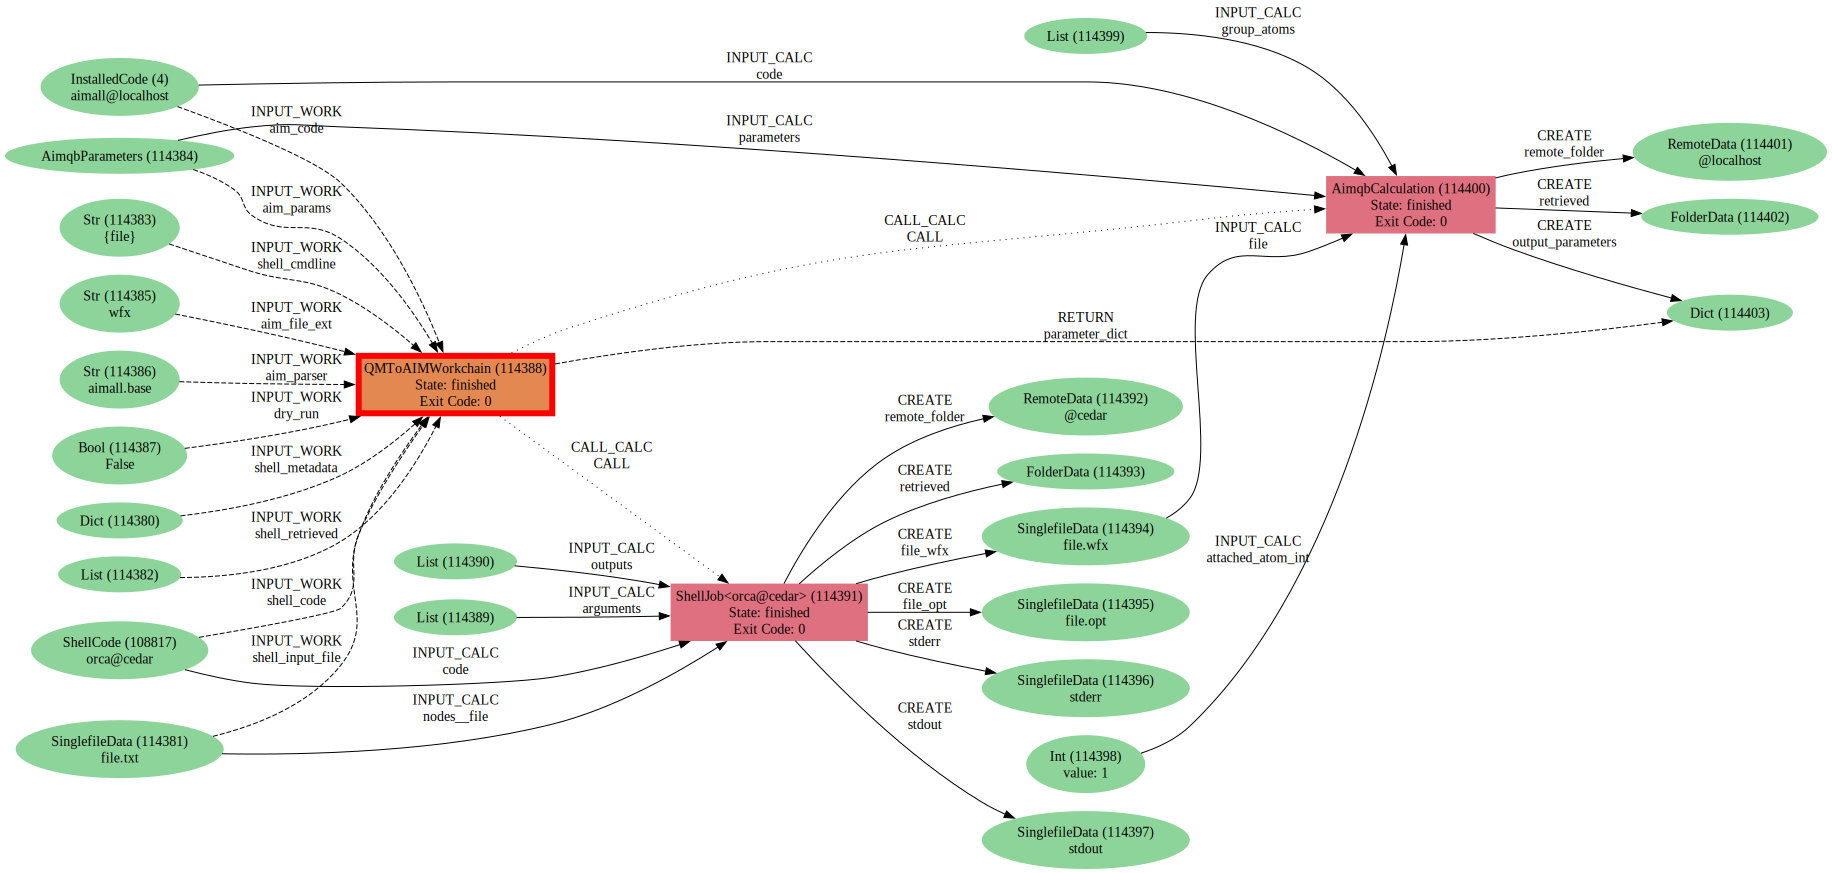

In [20]:
from aiida.tools.visualization import Graph
graph = Graph(graph_attr={"size": "6,6!", "rankdir": "LR"})
graph = Graph(graph_attr={"rankdir": "LR"})
graph.recurse_descendants(
    114388,
    origin_style=None,
    include_process_inputs=True,
    annotate_links="both"
)
graph.graphviz